<a href="https://colab.research.google.com/github/williamhpark/music_generation/blob/main/Music_Generating_Recurrent_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Music Generating Recurrent Neural Network

In this Colab notebook, we are creating a [Recurrent Neural Network (RNN)](https://www.ibm.com/topics/recurrent-neural-networks) machine learning model to "predict" the next note in a sequence of musical notes. This will be used to help us generate basic musical melodies.

We are using piano audio samples from the [MAESTRO dataset](https://magenta.tensorflow.org/datasets/maestro) to train this model. RNNs take information from prior inputs to influence the current input and output, and they're commonly used when dealing with time series data. For these reasons, an RNN is an appropriate choice for this model.

## Install and import libraries

We'll use the `pretty_midi` library to parse and create MIDI files.

In [1]:
!pip install pretty_midi

!sudo apt install -y fluidsynth
!pip install --upgrade pyfluidsynth

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 37.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 kB 3.2 MB/s eta 0:00:00
  Created wheel for pretty_midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592303 sha256=30f81f6cd730a7314ff672f2c028481ce663bd09a5e40d2621a0448c3aa6d1d0
  Stored in directory: /root/.cache/pip/wheels/75/ec/20/b8e937a5bcf1de547ea5ce465db7de7f6761e15e6f0a01e25f
Successfully built pretty_midi
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  fluid-soundfont-gm libfluidsynth2 libinstpatch-1.0-2 qsynth
  timgm6mb-soundfont
Suggested packages:
  fluid-soundfont-gs timidity jackd musescore
The following NEW packages will be installed:
  fluid-soundfont-gm fluidsynth libfluidsynth2 libinstpa

We'll also be using the `keras-tuner` library to determine the optimal set of hyperparameters for the model later in the notebook.

In [2]:
!pip install -q -U keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.2/172.2 kB 7.2 MB/s eta 0:00:00


In [3]:
import collections
# import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
# import seaborn as sns
import tensorflow as tf
import keras_tuner as kt

from IPython import display
# from matplotlib import pyplot as plt
# from typing import Optional
from tensorflow import keras

## Download raw MIDI data

The raw MIDI piano files used to train this model are downloaded from the MAESTRO dataset. The dataset contains almost 1,300 unique audio samples.

In [4]:
data_dir = pathlib.Path('data/maestro-v2.0.0')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'maestro-v2.0.0-midi.zip',
      origin='https://storage.googleapis.com/magentadata/datasets/maestro/v2.0.0/maestro-v2.0.0-midi.zip',
      extract=True,
      cache_dir='.', cache_subdir='data',
  )

59243107/59243107 [==============================] - 1s 0us/step


In [5]:
filenames = glob.glob(str(data_dir/'**/*.mid*'))
print('Number of files:', len(filenames))

Number of files: 1282


## Audio utility functions

Here, we define several utility functions that we'll use to interact with and convert the MIDI files.

### Display audio widget for a `pretty_midi` object

This function takes a `pretty_midi` object and displays an audio playback widget for it in Google Colab.

In [6]:
# Sampling rate for audio playback
SAMPLING_RATE = 16000

def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  waveform = pm.fluidsynth(fs=SAMPLING_RATE)
  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*SAMPLING_RATE]
  return display.Audio(waveform_short, rate=SAMPLING_RATE)

We can verify that this function works using the first file downloaded from the MAESTRO dataset.

In [7]:
sample_file = filenames[0]
pm = pretty_midi.PrettyMIDI(sample_file)
display_audio(pm)

In [8]:
print('Number of instruments:', len(pm.instruments))
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print('Instrument name:', instrument_name)

Number of instruments: 1
Instrument name: Acoustic Grand Piano


### Convert MIDI file to Pandas dataframe

This function takes the file path for a MIDI file and converts it to a Pandas dataframe, which can be used when training and evaluating the machine learning model.

We will use three variables to represent a note when training the model: pitch, step, and duration. The pitch is the perceptual quality of the sound as a MIDI note number. The step is the time elapsed from the previous note or start of the track. The duration is how long the note will be playing in seconds and is the difference between the note end and note start times.

In [9]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_file)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list)

  # Sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

Below we see how audio data for the first file from the MAESTRO dataset is populated into a dataframe.

In [10]:
raw_notes = midi_to_notes(sample_file)
raw_notes.head()

,pitch,start,end,step,duration
0,64,1.002604,1.704427,0.000000,0.701823
1,64,2.213542,2.744792,1.210938,0.531250
2,64,3.145833,3.263021,0.932292,0.117188
3,64,3.442708,4.821615,0.296875,1.378906
4,65,4.757812,6.152344,1.315104,1.394531


### Convert Pandas dataframe to MIDI file

This function does the opposite of the previous utility function - it takes a Pandas dataframe and converts it to a MIDI file, which can later be outputted to the user.

In [11]:
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str, 
  instrument_name: str,
  velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  
  return pm

We can use the `raw_notes` dataframe that we retrieved previously, pass this into the `notes_to_midi` function, then use the `display_audio` function to verify that the MIDI files are being converted properly. The playback widget displayed below should sound the same as the one that was generated earlier in this notebook.

In [12]:
example_file = 'example.midi'
example_pm = notes_to_midi(
    raw_notes, out_file=example_file, instrument_name=instrument_name)
display_audio(example_pm)

## Data pre-processing

Now, we perform some pre-processing to 1. normalize the data and 2. separate it into features and labels.

[Normalization](https://developers.google.com/machine-learning/data-prep/transform/normalization#:~:text=The%20goal%20of%20normalization%20is,training%20stability%20of%20the%20model.) is a strategy that's used to improve the performance of machine learning models. It's an important step in pre-processing numeric data. For our model we'll be normalizing the `pitch` values, transforming the values to be on a similar scale to the `step` and `duration` features.

First, we'll take data from the first x audio files and add them to a single dataframe.

In [13]:
num_files = 5 # Experiment with this number
all_notes = []
for f in filenames[:num_files]:
  notes = midi_to_notes(f)
  all_notes.append(notes)

all_notes = pd.concat(all_notes)
n_notes = len(all_notes)
print('Number of notes parsed:', n_notes)

Number of notes parsed: 23718


Next, we create a TensorFlow dataset from the parsed notes containing only the `pitch`, `step`, and `duration` data.

In [14]:
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

TensorSpec(shape=(3,), dtype=tf.float64, name=None)

We'll be training the model on batches of sequences of notes. Each example will consist of a sequence of notes as the input features, and the next note as the label. In this way, the model will be trained to predict the next note in a sequence.

In [15]:
def create_sequences(
    dataset: tf.data.Dataset, 
    seq_length: int,
    vocab_size = 128,
) -> tf.data.Dataset:
  """Returns TF Dataset of sequence and label examples."""
  # Make one additional space for the label
  seq_length = seq_length+1

  # Create a dataset of windows containing a subset of elements of the input dataset
  windows = dataset.window(seq_length, shift=1, stride=1, drop_remainder=True)

  # Flatten the "dataset of datasets" into a dataset of tensors
  sequences = windows.flat_map(lambda x: x.batch(seq_length, drop_remainder=True))
  
  # Normalize the `pitch` values
  def scale_pitch(x):
    x = x/[vocab_size,1.0,1.0]
    return x

  # Split the features and labels
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}
    return scale_pitch(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

In [16]:
seq_length = 25 # Experiment with this value manually
vocab_size = 128 # This represents all the pitches supported by `pretty_midi`
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec

(TensorSpec(shape=(25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(), dtype=tf.float64, name=None)})

## Training the model

Now that the data has been normalized and split into features/labels, we can start training the model.

First, we set the random seed for TensorFlow and NumPy. This is done so that results in this notebook are reproducible on separate runs.

In [17]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

We shuffle and batch the `seq_ds` to reduce overfitting.

In [18]:
batch_size = 64 # Experiment with this value
buffer_size = n_notes - seq_length # the number of items in the dataset
shuffled_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))
shuffled_ds.element_spec

(TensorSpec(shape=(64, 25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(64,), dtype=tf.float64, name=None)})

We can now split the shuffled/batched dataset into separate training and test datasets. The training dataset will, as the name suggests, be used to train the model. The test dataset will be used to evaluate the accuracy/loss of the model.

In [19]:
# 80% of the data for training, 20% for testing
train_size = int(0.8*buffer_size) 
test_size = int(0.2*buffer_size)

train_ds = shuffled_ds.take(train_size)
test_ds = shuffled_ds.skip(train_size).take(test_size)

Each one of the three outputs for this model (`pitch`, `step`, `duration`) needs a loss function. For `step` and `duration`, we will use a custom loss function based on [mean squared error](https://en.wikipedia.org/wiki/Mean_squared_error) that encourages the model to output non-negative values. For `pitch`, we will use the [`SparseCategoricalCrossentropy`](https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy) loss function from Keras, which computes the [cross entropy](https://en.wikipedia.org/wiki/Cross_entropy) loss between the labels and predictions.

In [20]:
# Custom loss function used for `step` and `duration`
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

This model has one hyperparameter that we want to tune: the learning rate, a value which controls the weights of our neural network with respect to the loss gradient. We'll use KerasTuner to find the optimal value for the learning rate with the objective of minimizing loss.

First, we create a model builder function to define the RNN model.

In [21]:
def model_builder(hp):
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-4, 1e-3, 1e-2, 1e-1, 5e-1, 1.0])

  input_shape = (seq_length, 3)
  inputs = tf.keras.Input(input_shape)
  x = tf.keras.layers.LSTM(128)(inputs)

  outputs = {
    'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
    'step': tf.keras.layers.Dense(1, name='step')(x),
    'duration': tf.keras.layers.Dense(1, name='duration')(x),
  }

  model = tf.keras.Model(inputs, outputs)

  loss = {
    'pitch': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    'step': mse_with_positive_pressure,
    'duration': mse_with_positive_pressure,
  }

  optimizer = tf.keras.optimizers.Adam(learning_rate=hp_learning_rate)
  
  model.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.05,
        'step': 1.0,
        'duration': 1.0,
    },
    optimizer=optimizer,
  )

  return model

Next, we specify the objective of the hyperparameter tuner: to minimize loss. We'll use the [Hyperband](https://arxiv.org/pdf/1603.06560.pdf) tuner. The Hyperband tuning algorithm uses adaptive resource allocation and early-stopping to quickly converge on a high-performing model. 

In [22]:
tuner = kt.Hyperband(model_builder,
                     objective=kt.Objective(name='loss',direction='min'),
                     max_epochs=10,
                     factor=3)

A callback will be used to stop training early after 5 epochs have passed with no improvement in loss.

In [23]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

We can now run the hyperparameter search to find the optimal hyperparameters.

In [24]:
tuner.search(train_ds, epochs=50, callbacks=callbacks)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 6 Complete [00h 01m 08s]
loss: 36.99955749511719

Best loss So Far: 0.25167325139045715
Total elapsed time: 00h 05m 23s


In [25]:
print(f"""
The optimal learning_rate is: {best_hps.get('learning_rate')}
""")


The optimal hyperparameters are:
- learning_rate: 0.01



Re-build the model using the optimal learning rate that was found.

In [26]:
hypermodel = tuner.hypermodel.build(best_hps)

Now, we train the model using the training dataset. We initially try 50 epochs, and we'll find an optimal number of epochs later.

In [27]:
history = hypermodel.fit(train_ds, epochs=50, callbacks=callbacks)

Epoch 1/50
370/370 [==============================] - 26s 64ms/step - loss: 0.2656 - duration_loss: 0.0418 - pitch_loss: 4.1584 - step_loss: 0.0159
Epoch 2/50
370/370 [==============================] - 17s 45ms/step - loss: 0.2516 - duration_loss: 0.0388 - pitch_loss: 4.0137 - step_loss: 0.0122
Epoch 3/50
370/370 [==============================] - 16s 43ms/step - loss: 0.2448 - duration_loss: 0.0381 - pitch_loss: 3.8959 - step_loss: 0.0119
Epoch 4/50
370/370 [==============================] - 18s 50ms/step - loss: 0.2422 - duration_loss: 0.0377 - pitch_loss: 3.8575 - step_loss: 0.0117
Epoch 5/50
370/370 [==============================] - 16s 43ms/step - loss: 0.2441 - duration_loss: 0.0382 - pitch_loss: 3.8817 - step_loss: 0.0119
Epoch 6/50
370/370 [==============================] - 18s 50ms/step - loss: 0.2415 - duration_loss: 0.0371 - pitch_loss: 3.8559 - step_loss: 0.0116
Epoch 7/50
370/370 [==============================] - 17s 45ms/step - loss: 0.2418 - duration_loss: 0.0374 - pit

Find the optimal number of epochs, where the loss was at a minimum.

In [28]:
val_loss_per_epoch = history.history['loss']
optimal_epochs = val_loss_per_epoch.index(min(val_loss_per_epoch)) + 1
print('Optimal number of epochs: %d' % (optimal_epochs))

Optimal number of epochs: 44


Now, we re-instantiate and re-train the model using the optimal number of epochs that was found.

In [29]:
hypermodel = tuner.hypermodel.build(best_hps)
history = hypermodel.fit(train_ds, epochs=optimal_epochs, callbacks=callbacks)

Epoch 1/44
370/370 [==============================] - 21s 49ms/step - loss: 0.2659 - duration_loss: 0.0421 - pitch_loss: 4.1411 - step_loss: 0.0167
Epoch 2/44
370/370 [==============================] - 16s 43ms/step - loss: 0.2496 - duration_loss: 0.0384 - pitch_loss: 3.9741 - step_loss: 0.0124
Epoch 3/44
370/370 [==============================] - 16s 43ms/step - loss: 0.2445 - duration_loss: 0.0385 - pitch_loss: 3.8823 - step_loss: 0.0118
Epoch 4/44
370/370 [==============================] - 17s 45ms/step - loss: 0.2433 - duration_loss: 0.0381 - pitch_loss: 3.8687 - step_loss: 0.0118
Epoch 5/44
370/370 [==============================] - 16s 44ms/step - loss: 0.2426 - duration_loss: 0.0376 - pitch_loss: 3.8613 - step_loss: 0.0119
Epoch 6/44
370/370 [==============================] - 18s 48ms/step - loss: 0.2404 - duration_loss: 0.0368 - pitch_loss: 3.8383 - step_loss: 0.0116
Epoch 7/44
370/370 [==============================] - 16s 43ms/step - loss: 0.2391 - duration_loss: 0.0363 - pit

We can use Matplotlib to visualize how the loss changes per epoch during training.

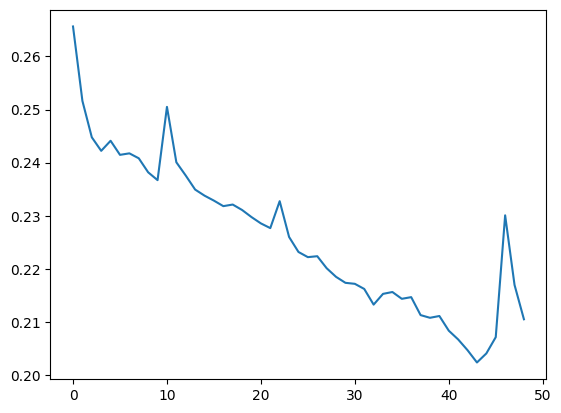

In [31]:
from matplotlib import pyplot as plt

plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

Finally, we can evaluate the hypermodel using the test dataset.

In [30]:
eval_result = hypermodel.evaluate(test_ds, return_dict=True)
print(eval_result)

370/370 [==============================] - 8s 21ms/step - loss: 0.2030 - duration_loss: 0.0208 - pitch_loss: 3.4723 - step_loss: 0.0086
{'loss': 0.2030431628227234, 'duration_loss': 0.020814159885048866, 'pitch_loss': 3.472287178039551, 'step_loss': 0.00861470215022564}


With the RNN model built, we now define a function that uses the model to predict the next note given a sequence of notes.

In [32]:
def predict_next_note(
    notes: np.ndarray, 
    keras_model: tf.keras.Model, 
    temperature: float = 1.0) -> tuple[int, float, float]:
  """Generates a note as a tuple of (pitch, step, duration), using a trained sequence model."""

  assert temperature > 0

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = hypermodel.predict(inputs)
  pitch_logits = predictions['pitch']
  step = predictions['step']
  duration = predictions['duration']
 
  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)

  # `step` and `duration` values should be non-negative
  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), float(step), float(duration)

We can repeatedly call the `predict_next_note` function to generate a unique sequence of notes.

In [33]:
temperature = 2.0
num_predictions = 120

sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(input_notes, hypermodel, temperature)
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(generated_notes, columns=(*key_order, 'start', 'end'))

1/1 [==============================] - 0s 28ms/step


Finally, we use the `notes_to_midi` utility function that we defined to play the generated sequence of notes.

In [34]:
out_file = 'output.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)
display_audio(out_pm)

Now that the model is trained and we know that it functions as we want it to, we can save the model and serve it using [TensorFlow Serving](https://www.tensorflow.org/tfx/guide/serving).

In [35]:
import tempfile
import os

MODEL_DIR = tempfile.gettempdir()
version = 1
export_path = os.path.join(MODEL_DIR, str(version))
print('export_path = {}\n'.format(export_path))

tf.keras.models.save_model(
    hypermodel,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)
print('\nSaved model:')
!ls -l {export_path}

export_path = /tmp/1




Saved model:
total 828
drwxr-xr-x 2 root root   4096 Apr 11 21:59 assets
-rw-r--r-- 1 root root     56 Apr 11 21:59 fingerprint.pb
-rw-r--r-- 1 root root  14941 Apr 11 21:59 keras_metadata.pb
-rw-r--r-- 1 root root 818205 Apr 11 21:59 saved_model.pb
drwxr-xr-x 2 root root   4096 Apr 11 21:59 variables


## References

- https://www.tensorflow.org/tutorials/audio/music_generation
- https://www.tensorflow.org/tutorials/keras/keras_tuner
- https://www.tensorflow.org/tfx/tutorials/serving/rest_simple